<a href="https://colab.research.google.com/github/robinjameslee/Listed-Options-Price-vs-Calculation/blob/main/Listed_Options_Price_vs_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from numpy import sqrt, log, exp, pi
from scipy.stats import norm

import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [ ]:
# 1st step - Query options chain data using yfinance package
def options_chain(ticker):
    tk = yf.Ticker(ticker)
    expiry_dates = tk.options
    options_df = pd.DataFrame()
    for e in expiry_dates:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expiryDate'] = pd.to_datetime(e)
        options_df = options_df.append(opt, ignore_index=True)

    # options_df['expiryDate'] = pd.to_datetime(options_df['expiryDate']) #+ datetime.timedelta(days = 1)
    options_df['spot'] = tk.fast_info['lastPrice']
    options_df['day_to_maturity'] = (options_df['expiryDate'] - datetime.datetime.today()).dt.days
    options_df['dte'] = options_df['day_to_maturity'] / 360
    options_df['optionType'] = options_df['contractSymbol'].str[4:].apply(lambda x: 'Call' if 'C' in x else 'Put')
    options_df[['bid', 'ask', 'strike']] = options_df[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options_df['mid'] = (options_df['bid'] + options_df['ask']) / 2
    options_df = options_df.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])
    return options_df

In [ ]:
# 2nd step - Create a function to calculation the implied volatility of an option
# We can use the Newton Raphson Algorithm to calculate the implied volatility
# This method uses vega as part of its calculation

# S = spot
# K = strike
# t = time to maturity
# r = risk-free rate
# sigma = annualized volatility
# option_type = Call or Put

N = norm.cdf

def bs_price(S, K, t, r, sigma, option_type):
    d1 = (log(S / K) + (r + sigma ** 2 / 2) * t) / (sigma * sqrt(t))
    d2 = d1 - sigma * sqrt(t)

    # black-scholes formula
    if option_type == 'Call':
        return N(d1) * S - N(d2) * K * exp(-r * t)
    elif option_type == 'Put':
        return N(-d2) * K * exp(-r * t) - N(-d1) * S

newton_tolerance = 0.05 # We'll stop calculate if difference between the market price and our calculated price is less than this
newton_iterations = 1000 # iterate it 10000 times

def vega(S, K, t, r, sigma):
    d1 = (log(S / K) + (r + sigma ** 2 / 2) * t) / (sigma * sqrt(t))
    vega = S  * sqrt(t) * norm.pdf(d1)
    return vega

def newton_iv(S, K, t, r, option_type, mkt_price):
    sigma = 0.5 # initial value
    for i in range(newton_iterations):
        iter_price = bs_price(S, K, t, r, sigma, option_type)
        diff = mkt_price - iter_price
        local_vega = vega(S, K, t, r, sigma)
        if abs(diff) < newton_tolerance:
            return sigma
        sigma += diff/local_vega
    return sigma

In [ ]:
ticker = 'TSLA'
tk_options = options_chain(ticker)
tk_options

,contractSymbol,strike,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,expiryDate,spot,day_to_maturity,dte,optionType,mid
0,TSLA230310C00015000,15.0,182.65,182.95,11.0,3.0,5.937503,True,2023-03-10,197.789993,5,0.013889,Call,182.800
1,TSLA230310C00020000,20.0,177.65,178.00,NaN,3.0,5.875003,True,2023-03-10,197.789993,5,0.013889,Call,177.825
2,TSLA230310C00030000,30.0,167.65,168.00,NaN,3.0,4.828129,True,2023-03-10,197.789993,5,0.013889,Call,167.825
3,TSLA230310C00040000,40.0,157.60,158.10,2.0,0.0,4.328130,True,2023-03-10,197.789993,5,0.013889,Call,157.850
4,TSLA230310C00050000,50.0,147.65,148.00,102.0,102.0,3.531251,True,2023-03-10,197.789993,5,0.013889,Call,147.825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4757,TSLA250620P00370000,370.0,178.70,181.35,2.0,441.0,0.362555,True,2025-06-20,197.789993,838,2.327778,Put,180.025
4758,TSLA250620P00380000,380.0,188.00,190.25,20.0,159.0,0.358145,True,2025-06-20,197.789993,838,2.327778,Put,189.125
4759,TSLA250620P00390000,390.0,196.55,199.50,2.0,158.0,0.357123,True,2025-06-20,197.789993,838,2.327778,Put,198.025
4760,TSLA250620P00400000,400.0,205.55,208.65,5.0,138.0,0.353705,True,2025-06-20,197.789993,838,2.327778,Put,207.100


In [ ]:
# 3rd step - We try to calculate the implied vol using our function
expiry_list = tk_options['expiryDate'].unique()
chosen_expiration = expiry_list[10]
interest_rate = 0 #let's assume it's 0% per annum
Calls = tk_options[(tk_options['expiryDate'] == chosen_expiration) & (tk_options['optionType'] == 'Call')]
Calls['cal_impliedVol'] = Calls.apply(lambda x: newton_iv(x['spot'], x['strike'], x['dte'], interest_rate, x['optionType'], x['mid']), axis=1)
Calls

<ipython-input-80-bba78aff8b6f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Calls['cal_impliedVol'] = Calls.apply(lambda x: newton_iv(x['spot'], x['strike'], x['dte'], interest_rate, x['optionType'], x['mid']), axis=1)


,contractSymbol,strike,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,expiryDate,spot,day_to_maturity,dte,optionType,mid,cal_impliedVol
2846,TSLA231117C00170000,170.0,55.10,55.85,11.0,37.0,0.657596,True,2023-11-17,197.789993,257,0.713889,Call,55.475,0.655722
2847,TSLA231117C00180000,180.0,49.55,50.30,1.0,17.0,0.644779,True,2023-11-17,197.789993,257,0.713889,Call,49.925,0.642717
2848,TSLA231117C00190000,190.0,44.65,45.05,16.0,74.0,0.634159,True,2023-11-17,197.789993,257,0.713889,Call,44.850,0.631630
2849,TSLA231117C00195000,195.0,42.25,42.70,16.0,77.0,0.629429,True,2023-11-17,197.789993,257,0.713889,Call,42.475,0.626835
2850,TSLA231117C00200000,200.0,39.95,40.40,29.0,256.0,0.624515,False,2023-11-17,197.789993,257,0.713889,Call,40.175,0.621989
2851,TSLA231117C00220000,220.0,31.85,32.30,2.0,58.0,0.609013,False,2023-11-17,197.789993,257,0.713889,Call,32.075,0.607305
2852,TSLA231117C00225000,225.0,30.10,30.55,3.0,57.0,0.606266,False,2023-11-17,197.789993,257,0.713889,Call,30.325,0.604838
2853,TSLA231117C00230000,230.0,28.40,28.85,20.0,167.0,0.603123,False,2023-11-17,197.789993,257,0.713889,Call,28.625,0.601991
2854,TSLA231117C00235000,235.0,26.90,27.30,2.0,126.0,0.601536,False,2023-11-17,197.789993,257,0.713889,Call,27.100,0.599777
2855,TSLA231117C00245000,245.0,23.85,24.35,3.0,214.0,0.595829,False,2023-11-17,197.789993,257,0.713889,Call,24.100,0.594113


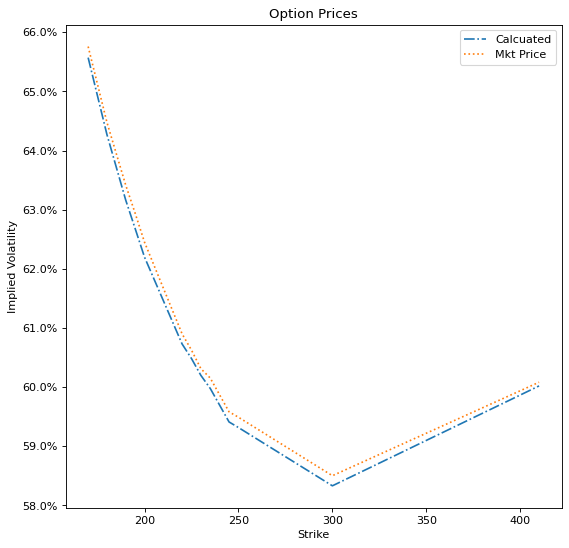

In [ ]:
# 4th step - Plot our results against market price
plt.figure(num=None, figsize=(8, 8), dpi=80)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.plot(Calls['strike'], Calls['cal_impliedVol'], label = 'Calcuated', linestyle = '-.')
plt.plot(Calls['strike'], Calls['impliedVolatility'], label = 'Mkt Price', linestyle = ':')
plt.legend()
plt.title('Option Prices')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.show()